# Doubly Robust Estimator - Example Notebook

The Doubly Robust Estimator (Jonsson Funk et al., 2011) combines a regression estimator with a propensity score estimator, yielding an estimator which is robust if either the regression model or the propensity score model is correctly specified. It models the potential outcomes with the following formula:

$Y^{DR}_{i, t} = \hat{m}(X_i, T_i=t) +  \frac{\mathbf{1}\{T_i=t\}}{\hat{e}(X_i)}\big(Y_i - \hat{m}(X_i,t)\big)$,

where $\hat{m}(X_i, t)$ is our outcome (regression) model and $\hat{e}(X_i)$ is our propensity score model.

## To see it in action, we'll walk through an example. 

Lets imagine we are trying to estimate the average-treatment-effect (ATE) of our data, and we believe two things to be true:
* **(Assumption A)**: The potential outcomes of our data are accurately modeled as a linear function of the treatment plus the common causes.
* **(Assumption B)**: The propensity score of our data is accurately modeled by just a few axis-aligned splits, which can be represented with a decision tree.

We will compare three estimators of the ATE: a linear regression estimator, a propensity score weighting estimator which models the propensity score as a decision tree, and finally the doubly robust estimator which combines the two. We will specifically compare these estimators in two situations.

* When **Assumption A** is true but **Assumption B** is false.
* When **Assumption B** is true but **Assumption A** is false.

Ultimately, we will see that as long as just one of the assumptions is true, the Doubly Robust Estimator is consistent and yields a good estimate for the ATE. The other two estimators, on the other hand, will perform more poorly when they are misspecified.

In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Generate Data

Lets generate two datasets: 
* **df_linear** will follow a linear outcome model and will have a linear propensity score model.
* **df_nonlinear** will follow an explicitly non-linear outcome model, and will have a nonlinear propensity score model which satisfies just two axis-aligned boundary splits (and so is easily modeled using a decision tree).

In [2]:
ATE = 10

# ========================================================
# Lets start by using the linear_dataset() helper method, but we will tweak the values to fit our toy example
data = dowhy.datasets.linear_dataset(beta=ATE,
        num_common_causes=2, 
        num_instruments = 0,
        num_treatments=1,
        num_samples=20000,
        treatment_is_binary=True,
        outcome_is_binary=False,
        stddev_treatment_noise=10)
df_base = data["df"]

# ========================================================
# Helper methods
mean_w0 = df_base["W0"].mean()
mean_w1 = df_base["W1"].mean()
def assign_treatment_linear(row):
    linear_term = 1.5*row["W0"] + 1.5*row["W1"]
    prob = 1 / (1 + np.exp(-1 * linear_term))
    return np.random.binomial(1, prob)
def assign_treatment_nonlinear(row):
    if (row["W0"] < mean_w0 and row["W1"] < mean_w1):
        return int(np.random.rand() < 0.9)
    return int(np.random.rand() < 0.1)
def assign_effect_linear(row, ate):
    return 6.5 * row["W0"] + 5.5 * row["W1"] + ate * row["v0"]
def assign_effect_nonlinear(row, ate):
    if (row["W0"] < mean_w0 and row["W1"] < mean_w1):
        return 2 * (row["W0"]**2) + 2 * (row["W1"] ** 2) + ate * row["v0"]
    return 2 * (row["W0"] ** 3) + 2 * (row["W1"] ** 3) + ate * row["v0"]

# ========================================================
# Specify linear data such that propensity scores are also linear
df_linear = df_base.copy(deep=True)
df_linear["v0"] = df_linear.apply(assign_treatment_linear, axis=1)
df_linear["y"] = df_linear.apply(assign_effect_linear, axis=1, args=(ATE,))

# ========================================================
# Specify linear data such that propensity scores are nonlinear
df_nonlinear = df_base.copy(deep=True)
df_nonlinear["v0"] = df_nonlinear.apply(assign_treatment_nonlinear, axis=1)
df_nonlinear["y"] = df_nonlinear.apply(assign_effect_nonlinear, axis=1, args=(ATE,))

## Visualizing the Treatment Assignment Data

The visual below helps capture the relationship between the common causes and the treatment assignment, in our synthetically generated data. In the linear setting, it is not possible for the decision tree classifier to provide an accurate model of the propensity scores. Meanwhile, in the  non-linear setting, the linear outcome model will not accurately model the effects. 

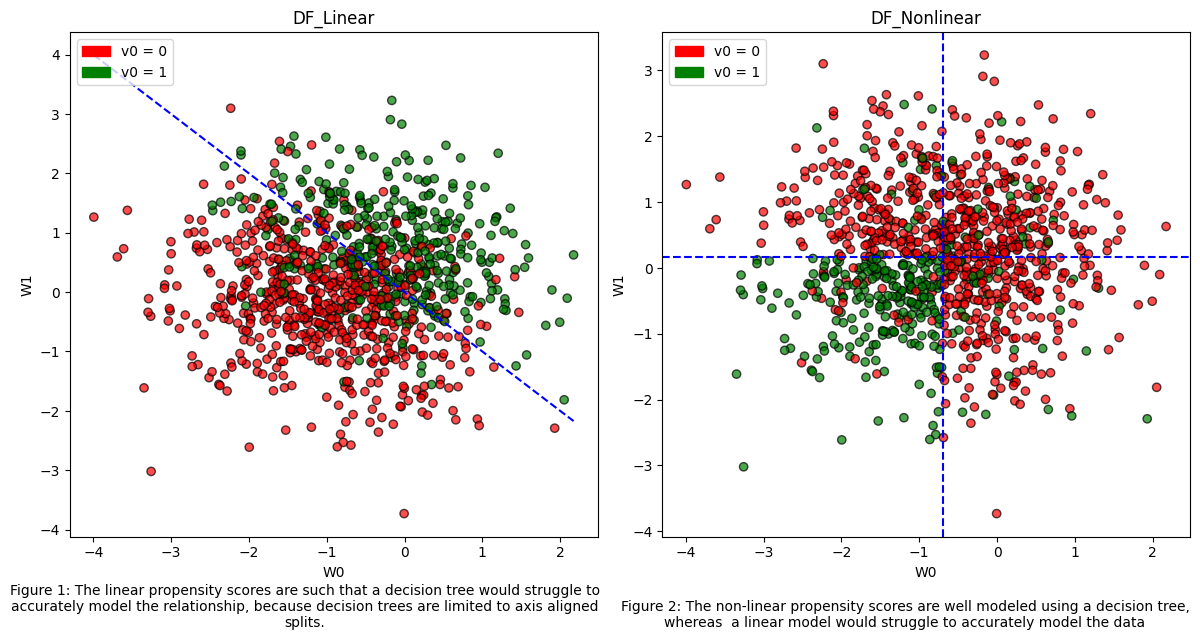

In [3]:
df_linear_sample = df_linear.sample(n=1000, random_state=0)
colors_linear = df_linear_sample["v0"].map({0: "red", 1: "green"})
df_nonlinear_sample = df_nonlinear.sample(n=1000, random_state=0)
colors_nonlinear = df_nonlinear_sample["v0"].map({0: "red", 1: "green"})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ========================================================
# Left plot: Linear
ax = axes[0]
ax.scatter(df_linear_sample["W0"], df_linear_sample["W1"], c=colors_linear, alpha=0.7, edgecolor="k")
x_vals = np.linspace(df_linear_sample["W0"].min(), df_linear_sample["W0"].max(), 200)
ax.plot(x_vals, -x_vals, color="blue", linestyle="--", label="W1 = -W0")
ax.set_xlabel("W0")
ax.set_ylabel("W1")
ax.set_title("DF_Linear")
red_patch = mpatches.Patch(color="red", label="v0 = 0")
green_patch = mpatches.Patch(color="green", label="v0 = 1")
ax.legend(handles=[red_patch, green_patch], loc="upper left")

# ========================================================
# Right plot: Nonlinear
ax = axes[1]
ax.scatter(df_nonlinear_sample["W0"], df_nonlinear_sample["W1"], c=colors_nonlinear, alpha=0.7, edgecolor="k")
ax.axvline(x=mean_w0, color="blue", linestyle="--", label=f"Mean W0 = {mean_w0:.2f}")
ax.axhline(y=mean_w1, color="blue", linestyle="--", label=f"Mean W1 = {mean_w1:.2f}")
ax.set_xlabel("W0")
ax.set_ylabel("W1")
ax.set_title("DF_Nonlinear")
ax.legend(handles=[red_patch, green_patch], loc="upper left")

# ========================================================
# Display
fig.text(0.25, -0.05,
         "Figure 1: The linear propensity scores are such that a decision tree "
         "would struggle to accurately model the relationship, "
         "because decision trees are limited to axis aligned splits.",
         wrap=True, ha="center", fontsize=10)

fig.text(0.75, -0.05,
         "Figure 2: The non-linear propensity scores are well modeled using a decision tree, whereas "
         " a linear model would struggle to accurately model the data",
         wrap=True, ha="center", fontsize=10)

plt.tight_layout()
plt.show()


## Initialize Causal Models & Identify Estimand

In [4]:
model_linear=CausalModel(
    data = df_linear,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
    instruments=data["instrument_names"]
)
model_nonlinear=CausalModel(
    data = df_nonlinear,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
    instruments=data["instrument_names"]
)

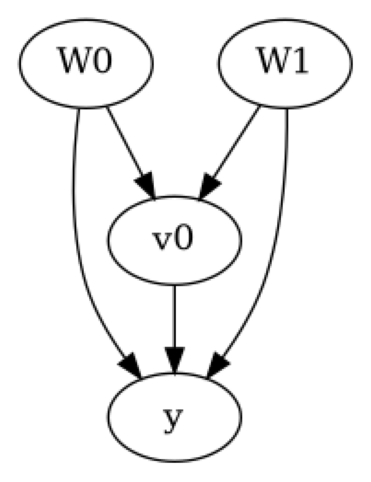

In [5]:
model_linear.view_model()

In [6]:
identified_estimand = model_linear.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate Effect

Now, we will compare our three estimators: the Doubly Robust Estimator, against its individual sub-components: the linear regression estimator and the propensity score estimator. We will compare these across both datasets, to see if in fact the Doubly Robust Estimator performs well on both **df_linear** which follows a true linear model, and **df_nonlinear** which follows a non-linear model but has a propensity score model which can be well modeled with our assumed decision tree.

In all cases, the true ATE is 10.0.

### DF_Linear

**Linear model**

In [7]:
causal_estimate_reg = model_linear.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=False)
reg_estimate_lin_model = causal_estimate_reg.value
print("Causal Estimate of Linear Outcome Model is " + str(reg_estimate_lin_model))

Causal Estimate of Linear Outcome Model is 10.0


**Propensity score model**

In [8]:
causal_estimate_ipw = model_linear.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        target_units = "ate",
        method_params={
            "weighting_scheme":"ips_weight",
            "propensity_score_model":DecisionTreeClassifier(max_depth=2, min_samples_leaf=2000, random_state=42)
        })
prop_estimate_lin_model = causal_estimate_ipw.value
print("Causal Estimate of Propensity Score Weighting (with Decision Tree Classifier) is " + str(prop_estimate_lin_model))

Causal Estimate of Propensity Score Weighting (with Decision Tree Classifier) is 14.880900845716727


**Doubly robust model**

In [9]:
causal_estimate_dr = model_linear.estimate_effect(identified_estimand,
        method_name="backdoor.doubly_robust",
        target_units = "ate",
        method_params={
            "propensity_score_model": DecisionTreeClassifier(max_depth=2, min_samples_leaf=2000, random_state=42),
            "propensity_score_column":"propensity_score_dr"
        })
dr_estimate_lin_model = causal_estimate_dr.value
print("Causal Estimate of Doubly Robust Estimator is " + str(dr_estimate_lin_model))

Causal Estimate of Doubly Robust Estimator is 10.000000000000002


### DF_Nonlinear

In [10]:
causal_estimate_reg = model_nonlinear.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
reg_estimate_nonlin_model = causal_estimate_reg.value
print("Causal Estimate of Linear Outcome Model is " + str(reg_estimate_nonlin_model))

Causal Estimate of Linear Outcome Model is 20.47002003306398


In [11]:
causal_estimate_ipw = model_nonlinear.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        target_units = "ate",
        method_params={
            "weighting_scheme":"ips_weight",
            "propensity_score_model":DecisionTreeClassifier(max_depth=2, min_samples_leaf=2000, random_state=42)  # , min_samples_leaf=2000,
        })
prop_estimate_nonlin_model = causal_estimate_ipw.value
print("Causal Estimate of Propensity Score Weighting (with Decision Tree Classifier) is " + str(prop_estimate_nonlin_model))

Causal Estimate of Propensity Score Weighting (with Decision Tree Classifier) is 10.183180704633108


In [12]:
causal_estimate_dr = model_nonlinear.estimate_effect(identified_estimand,
        method_name="backdoor.doubly_robust",
        target_units = "ate",
        method_params={
            "propensity_score_model": DecisionTreeClassifier(max_depth=2, min_samples_leaf=2000, random_state=42),
            "propensity_score_column":"propensity_score_dr"
        })
dr_estimate_nonlin_model = causal_estimate_dr.value
print("Causal Estimate of Doubly Robust Estimator is " + str(dr_estimate_nonlin_model))

Causal Estimate of Doubly Robust Estimator is 10.146944863891163


### Comparing Results

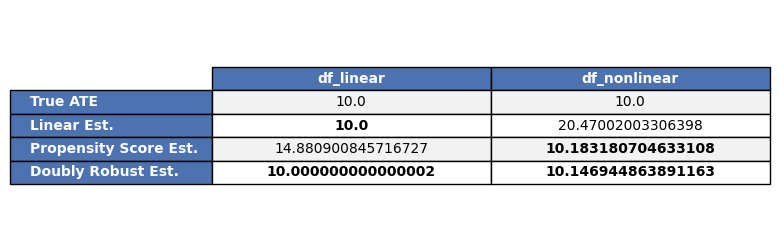

In [13]:
# ========================================================
# Building table
row_labels = ["True ATE", "Linear Est.", "Propensity Score Est.", "Doubly Robust Est."]
col_labels = ["df_linear", "df_nonlinear"]
data = [
    [10.0, 10.0],
    [reg_estimate_lin_model, reg_estimate_nonlin_model],
    [prop_estimate_lin_model, prop_estimate_nonlin_model],
    [dr_estimate_lin_model, dr_estimate_nonlin_model],
]
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("off")
table = ax.table(
    cellText=data,
    rowLabels=row_labels,
    colLabels=col_labels,
    loc="center",
    cellLoc="center"
)

# ========================================================
# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.4)
for i in range(len(row_labels)):  # Add alternating row colors
    for j in range(len(col_labels)):
        cell = table[(i+1, j)]
        if i % 2 == 0:
            cell.set_facecolor("#f2f2f2")
        else:
            cell.set_facecolor("white")
for key, cell in table.get_celld().items():  # Bold headers
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight="bold", color="white")
        cell.set_facecolor("#4c72b0")
table[(2, 0)].get_text().set_weight("bold")  # Custom bolding for specific cells
table[(4, 0)].get_text().set_weight("bold")
table[(3, 1)].get_text().set_weight("bold")
table[(4, 1)].get_text().set_weight("bold")

## References

1. Michele Jonsson Funk, Daniel Westreich, Chris Wiesen, Til Stürmer,  M. Alan Brookhart, Marie Davidian, Doubly Robust Estimation of Causa   Effects, American Journal of Epidemiology, Volume 173, Issue     1 April 2011, Pages 761-767, https://doi.org/10.1093/aje/kwq439